In [1]:
import pandas as pd
import numpy as np
import os

# read preprocessed data
cwd = os.getcwd()
df = pd.read_csv(cwd + "/data_csv/preprocessing_data.csv")
df.to_csv(cwd + "/data_csv/feature_data.csv", index=False)

In [2]:
df.groupby('emotion').count()

df

,image,emotion
0,facial-expressions_2868585k.jpg,7
1,facial-expressions_2868582k.jpg,3
2,Aaron_Peirsol_0003.jpg,4
3,Aaron_Sorkin_0002.jpg,4
4,Abdel_Nasser_Assidi_0002.jpg,5
...,...,...
24108,SURPRISE/surprise (971).png,7
24109,SURPRISE/surprise (978).jpg,7
24110,SURPRISE/surprise (981).png,7
24111,SURPRISE/surprise (983).jpg,7


In [3]:
def get_distance(fist_point, second_point):
    distance =  math.sqrt(math.pow(fist_point[0] - second_point[0], 2) + math.pow(fist_point[1] - second_point[1], 2))
    return abs(distance)

def get_angle(first_point, second_point):
    value = (second_point[1] - first_point[1]) / (second_point[0] - first_point[0])
    angle = math.atan(value)
    return angle

len(df)


24113

In [4]:
import cv2, math, numpy as np, dlib
from imutils import face_utils

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(cwd + "/predictor/shape_predictor_68_face_landmarks.dat")

mlist = []
distlist = []
eye_size_list = []
eye_brows_list = []
width_left_eyes =[]
width_right_eyes = []
width_mount = []
height_mount = []
height_mount_chin = []
left_eye_list = []
right_eye_list = []
angle_left_eyebrow = []
angle_right_eyebrow = []
dis_c_lmount_nose = []
dis_c_rmount_nose = []
d_first_eyebrow_leye = []
d_first_eyebrow_reye = []
a_nose_leyebrow = []
a_nose_reyebrow = []
circum_mount = []
d_bottom_mount_chin = []


emotion_list = [0 for x in range(8)]


error = []

# run each row in train.csv
for idx, row in df.iterrows():
    try:
        imagePath = cwd + "/cleaned_images/" + row.image
        image = cv2.imread(imagePath)

        rects = detector(image, 0)

        xlist = []
        ylist = []
        if(emotion_list[row.emotion] > 2300):
            error.append(idx)
            continue
        # loop over the face detections
        for (i, rect) in enumerate(rects):
            # determine the facial landmarks and convert the facial landmark (x, y)
            shape = predictor(image, rect)
            shape = face_utils.shape_to_np(shape)

            # loop over coordinates, draw them on the image and store coordinates in two lists
            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
                xlist.append(x)
                ylist.append(y)

        # get mean of both axes to determine centre of gravity
        xmean = np.mean(xlist) 
        ymean = np.mean(ylist)

        # plot central face on image
        cv2.circle(image, (int(xmean), int(ymean)), 1, (0, 255, 0), -1)

        # find distance between mouth
        mavg = np.mean([ylist[61] - ylist[67], ylist[62] - ylist[66], ylist[63] - ylist[65]])

        # find distance between left eye
        left_eye_avg = np.mean([
            get_distance([xlist[37], ylist[37]], [xlist[40], ylist[40]]),
            get_distance([xlist[38], ylist[38]], [xlist[41], ylist[41]])
        ])
        # find distance between right eye
        right_eye_avg = np.mean([
            get_distance([xlist[43], ylist[43]], [xlist[46], ylist[46]]),
            get_distance([xlist[44], ylist[44]], [xlist[47], ylist[47]])
        ])
        # find distance between eye browns
        eye_brows = np.mean([ylist[24] - ylist[26], ylist[19] - ylist[17]])

        # find distance between every poin to central point
        templist = []
        for i in range(17, 68):
            dist = math.sqrt(math.pow(xlist[i] - xmean, 2) + math.pow(ylist[i] - ymean, 2))
            templist.append(dist)
        distavg = np.mean(dist)
        
        mlist.append(mavg) # 1
        left_eye_list.append(left_eye_avg)
        right_eye_list.append(right_eye_avg)
        width_left_eyes.append(get_distance([xlist[36], ylist[36]], [xlist[39], ylist[39]]))
        width_right_eyes.append(get_distance([xlist[42], ylist[42]], [xlist[45], ylist[45]]))
        width_mount.append(get_distance([xlist[48], ylist[48]], [xlist[54], ylist[54]]))
        height_mount.append(get_distance([xlist[51], ylist[51]], [xlist[57], ylist[57]]))
        height_mount_chin.append(get_distance([xlist[51], ylist[51]], [xlist[8], ylist[8]]))
        angle_left_eyebrow.append(get_angle([xlist[17], ylist[17]], [xlist[18], ylist[18]]))
        angle_right_eyebrow.append(get_angle([xlist[26], ylist[26]], [xlist[25], ylist[25]]))
        eye_brows_list.append(eye_brows)
        dis_c_lmount_nose.append(get_distance([xlist[33], ylist[33]], [xlist[48], ylist[48]]))
        dis_c_rmount_nose.append(get_distance([xlist[33], ylist[33]], [xlist[54], ylist[54]]))
        d_first_eyebrow_leye.append(get_distance([xlist[21], ylist[21]], [xlist[39], ylist[39]]))
        d_first_eyebrow_reye.append(get_distance([xlist[22], ylist[22]], [xlist[42], ylist[42]]))
        a_nose_leyebrow.append(get_angle([xlist[21], ylist[21]], [xlist[27], ylist[27]]))
        a_nose_reyebrow.append(get_angle([xlist[42], ylist[42]], [xlist[22], ylist[22]]))
        distlist.append(distavg) 
        circum_mount.append([get_distance([xlist[x], ylist[x]], [xlist[x + 1], ylist[x + 1]]) for x in range(60, 67)])
        d_bottom_mount_chin.append(get_distance([xlist[57], ylist[57]], [xlist[8], ylist[8]]))
        emotion_list[row.emotion] += 1
        cv2.imshow("Output", image)# 
        # k = cv2.waitKey(5) & 0xFF
        # if k == 68:
        #     break
        # 20
    except:
        error.append(idx)
        continue

/var/folders/dj/6xj2_ws50cn8fvd7lpqt77l80000gn/T/ipykernel_20872/3441831444.py:6: RuntimeWarning: divide by zero encountered in long_scalars
  value = (second_point[1] - first_point[1]) / (second_point[0] - first_point[0])
/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
# df = new_df.copy()
new_df = df.copy()
df


,image,emotion
0,facial-expressions_2868585k.jpg,7
1,facial-expressions_2868582k.jpg,3
2,Aaron_Peirsol_0003.jpg,4
3,Aaron_Sorkin_0002.jpg,4
4,Abdel_Nasser_Assidi_0002.jpg,5
...,...,...
24108,SURPRISE/surprise (971).png,7
24109,SURPRISE/surprise (978).jpg,7
24110,SURPRISE/surprise (981).png,7
24111,SURPRISE/surprise (983).jpg,7


In [6]:
df.drop(error, axis=0, inplace=True)
print(len(df))

16694


In [7]:
# add feature to df
print(len(df), len(mlist))
df['mouth_distance'] = mlist # 1
df['average_distance'] = distlist
df['size_left_eye'] = left_eye_list
df['size_right_eye']  = right_eye_list
# print(len(eye_brows_list))
df['eye_brows'] = eye_brows_list
df['w_left_eye'] = width_left_eyes
df['w_right_eye'] = width_right_eyes
df['w_mount'] = width_mount
df['h_mount'] = height_mount
df['h_chin'] = height_mount_chin
# print(len(angle_left_eyebrow))
df['angle_left_eyebrow'] = angle_left_eyebrow
df['angle_right_eyebrow'] = angle_right_eyebrow
df['dis_c_lmount_nose'] = dis_c_lmount_nose
df['dis_c_rmount_nose'] = dis_c_rmount_nose 
df['d_first_eyebrow_leye'] = d_first_eyebrow_leye
df['d_first_eyebrow_reye'] = d_first_eyebrow_reye
df['a_nose_leyebrow'] = a_nose_leyebrow
df['a_nose_reyebrow'] = a_nose_reyebrow
df['circum_mount'] = circum_mount
df['d_bottom_mount_chin'] = d_bottom_mount_chin
# 20 Features


16694 16694


In [8]:
df
new_df = df.copy()

In [9]:
df.groupby('emotion').count()

,image,mouth_distance,average_distance,size_left_eye,size_right_eye,eye_brows,w_left_eye,w_right_eye,w_mount,h_mount,...,angle_left_eyebrow,angle_right_eyebrow,dis_c_lmount_nose,dis_c_rmount_nose,d_first_eyebrow_leye,d_first_eyebrow_reye,a_nose_leyebrow,a_nose_reyebrow,circum_mount,d_bottom_mount_chin
emotion,,,,,,,,,,,,,,,,,,,,,
0,2301,2301,2301,2301,2301,2301,2301,2301,2301,2301,...,2301,2301,2301,2301,2301,2301,2301,2301,2301,2301
1,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,...,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677
2,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566,...,1566,1566,1566,1566,1566,1566,1566,1566,1566,1566
3,1994,1994,1994,1994,1994,1994,1994,1994,1994,1994,...,1994,1994,1994,1994,1994,1994,1994,1994,1994,1994
4,2301,2301,2301,2301,2301,2301,2301,2301,2301,2301,...,2301,2301,2301,2301,2301,2301,2301,2301,2301,2301
5,2301,2301,2301,2301,2301,2301,2301,2301,2301,2301,...,2301,2301,2301,2301,2301,2301,2301,2301,2301,2301
6,2268,2268,2268,2268,2268,2268,2268,2268,2268,2268,...,2268,2268,2268,2268,2268,2268,2268,2268,2268,2268
7,2286,2286,2286,2286,2286,2286,2286,2286,2286,2286,...,2286,2286,2286,2286,2286,2286,2286,2286,2286,2286


20


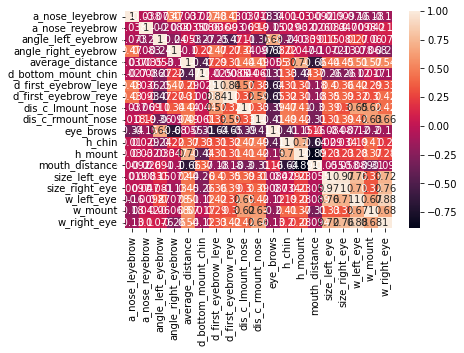

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt
X = df[df.columns.difference(['Unnamed: 0', 'emotion', 'image'])]
corr = X.corr()

sns.heatmap(corr, annot=True)
print(len(X.columns))


In [12]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

print("Filter Method : ", len(corr.columns[columns]))
selected_columns = list(corr.columns[columns]) + ['emotion', 'image']
print(selected_columns)
# data = corr[selected_columns]
# print(selected_columns)
# selected_columns.append('emotion')

Filter Method :  18
['a_nose_leyebrow', 'a_nose_reyebrow', 'angle_left_eyebrow', 'angle_right_eyebrow', 'average_distance', 'd_bottom_mount_chin', 'd_first_eyebrow_leye', 'd_first_eyebrow_reye', 'dis_c_lmount_nose', 'dis_c_rmount_nose', 'eye_brows', 'h_chin', 'h_mount', 'mouth_distance', 'size_left_eye', 'w_left_eye', 'w_mount', 'w_right_eye', 'emotion', 'image']


In [13]:
df_filter = new_df.copy()
print(new_df)
df_filter = df_filter[selected_columns]
print(df_filter)

                                 image  emotion  mouth_distance  \
0      facial-expressions_2868585k.jpg        7      -28.666667   
1      facial-expressions_2868582k.jpg        3       -3.000000   
2               Aaron_Peirsol_0003.jpg        4      -13.333333   
3                Aaron_Sorkin_0002.jpg        4      -20.000000   
4         Abdel_Nasser_Assidi_0002.jpg        5        1.666667   
...                                ...      ...             ...   
24108      SURPRISE/surprise (971).png        7       -3.333333   
24109      SURPRISE/surprise (978).jpg        7      -19.666667   
24110      SURPRISE/surprise (981).png        7      -47.666667   
24111      SURPRISE/surprise (983).jpg        7      -23.333333   
24112      SURPRISE/surprise (994).jpg        7      -13.333333   

       average_distance  size_left_eye  size_right_eye  eye_brows  w_left_eye  \
0             57.849661      20.048945       19.091883      -14.0   38.639358   
1             38.702801      17.6

In [14]:
# Critical To Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
model= RandomForestClassifier(n_estimators=250, random_state=7)
X=df[df.columns.difference(['emotion', 'image'])]
y = df[['emotion']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
model.fit(X_train, y_train)  
fs=pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)

fs.plot(kind='barh')

In [ ]:
important = list(model.feature_importances_)
print(important)

[0.045624340393174596, 0.048315161020838764, 0.042245818330894455, 0.04172232190798239, 0.06450920443617744, 0.05113266280046044, 0.05304181013274769, 0.05486440698022484, 0.05438430162186854, 0.05179313738147718, 0.04092973596356051, 0.04860021659488233, 0.05278890265140638, 0.06972499335316396, 0.0663276264264235, 0.056693899815619446, 0.10355418436681403, 0.05374727582228352]


In [ ]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE

X_1 = sm.add_constant(X)
model = sm.OLS(y,X_1).fit()
model.pvalues



const                   8.374295e-04
a_nose_leyebrow         5.475920e-03
a_nose_reyebrow         4.581391e-02
angle_left_eyebrow      3.710038e-01
angle_right_eyebrow     9.617374e-01
average_distance        4.765528e-16
d_bottom_mount_chin     9.105866e-01
d_first_eyebrow_leye    6.390265e-04
d_first_eyebrow_reye    2.684247e-06
dis_c_lmount_nose       8.547281e-01
dis_c_rmount_nose       7.010307e-01
eye_brows               3.084998e-02
h_chin                  8.641947e-01
h_mount                 8.819120e-01
mouth_distance          3.409091e-03
size_left_eye           9.119661e-04
w_left_eye              5.291927e-02
w_mount                 2.828505e-02
w_right_eye             4.625659e-04
dtype: float64

In [ ]:
# 2. Wrapper Methods
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = list(cols)
print("Number of Feature Selected BE : ", len(selected_features_BE))
print(selected_features_BE)

Number of Feature Selected :  11
['a_nose_leyebrow', 'a_nose_reyebrow', 'average_distance', 'd_first_eyebrow_leye', 'd_first_eyebrow_reye', 'eye_brows', 'h_chin', 'mouth_distance', 'size_left_eye', 'w_mount', 'w_right_eye']


In [ ]:
#no of features
nof_list=np.arange(1,21)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 14
Score with 14 features: 0.164168


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, n_features_to_select=14)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y) 
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)
cols = list(X.columns)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = list(temp[temp==True].index)
print("Number of feature rfe : ", len(selected_features_rfe))


[ True  True  True  True  True False  True  True False False  True  True
  True  True  True  True False  True]
[1 1 1 1 1 3 1 1 5 4 1 1 1 1 1 1 2 1]
Number of feature rfe :  14


In [ ]:
# selected_features_rfe = selected_features_rfe.extend(['emotion', 'image'])
selected_features_rfe = ['image', 'emotion'] + selected_features_rfe
df_wrapper = new_df.copy()
df_wrapper = df_wrapper[selected_features_rfe]
df_wrapper.to_csv(cwd + "/data_csv/use_feature_data_wrapper.csv", index=False)


In [ ]:
# Embedded
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 1.193809
Best score using built-in LassoCV: 0.137094


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.705425072072103, tolerance: 1.3774912039925145
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.299124760989798, tolerance: 1.3774912039925145
  model = cd_fast.enet_coordinate_descent_gram(


In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 5 variables and eliminated the other 13 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

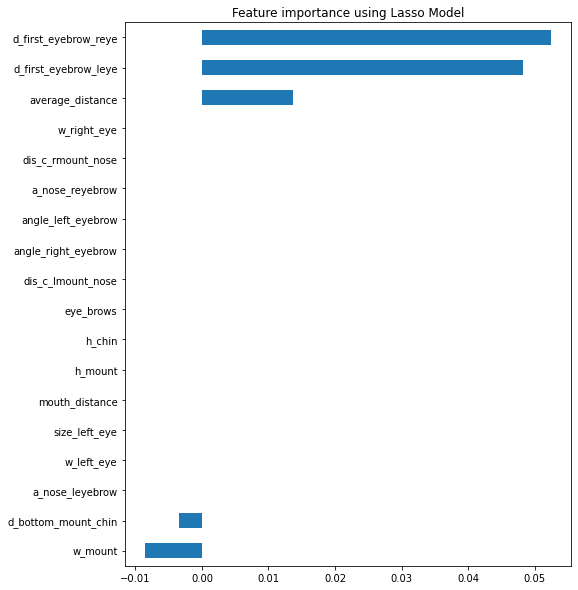

In [ ]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [ ]:
feature_selected_embed = [
    'image',
    'emotion',
    'd_first_eyebrow_reye',
    'd_first_eyebrow_leye', 
    'average_distance',
    'd_bottom_mount_chin',
    'w_mount'
]
df_embedded = new_df.copy()
df_embedded = df_embedded[feature_selected_embed]
print(len(df_embedded.columns))
df_embedded.to_csv(cwd + "/data_csv/use_feature_data_embedded.csv", index=False)


7


In [ ]:
# Wrapper Methods
from sklearn.ensemble import GradientBoostingClassifier
estimator = GradientBoostingClassifier(n_estimators = 100)
selector = RFE(estimator, step= 1)
selector = selector.fit(X_train, y_train)

In [ ]:
sel_cols = np.array(X.columns)[selector.support_]
sel_cols